In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from torch import nn
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold, KFold

from datetime import datetime

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

Using TensorFlow backend.


## Settings

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'

IMAGE_COLOR = 'red'   # 'red','green'

IMAGE_TYPE = 'L'    # 'L' for greyscale, 'RGB'for color, 'P' for palette images

TILE_SHAPE = (540,540)    # desired input size
MASK_SHAPE = (356,356)       # 540-184
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{IMAGE_COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
PADDING = tuple(np.subtract(TILE_SHAPE,MASK_SHAPE))

Training Params

In [0]:
BATCH_SIZE = 4
N_SPLITS = 10
WEIGHT_DECAY = 0.001
INITIAL_KFOLD = True

Network Params

In [0]:
IN_CHANNELS = 1 
N_CLASSES = 2  #number of classes
DEPTH = 5
BATCH_NORM = True #batch normalization after first layer

# Custom Net Overview

In [0]:
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        batch_norm=BATCH_NORM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
       BatchNorm2d-8        [-1, 128, 266, 266]             256
            Conv2d-9        [-1, 128, 264, 264]         147,584
             ReLU-10        [-1, 128, 264, 264]               0
      BatchNorm2d-11        [-1, 128, 264, 264]             256
    UNetConvBlock-12        [-1, 128, 264, 264]               0
           Conv2d-13        [-1, 256, 130, 130]         295,168
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] # get list with img_ids
imgExt = os.path.splitext(filenames[0])[1]                    # get image extension

In [0]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### Change regDigits if filenames have a different structure

regDigits = '\d{4}'
maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

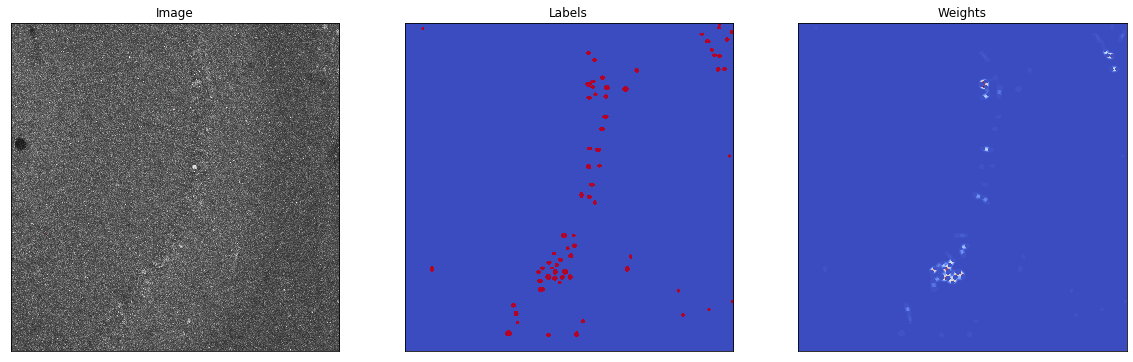

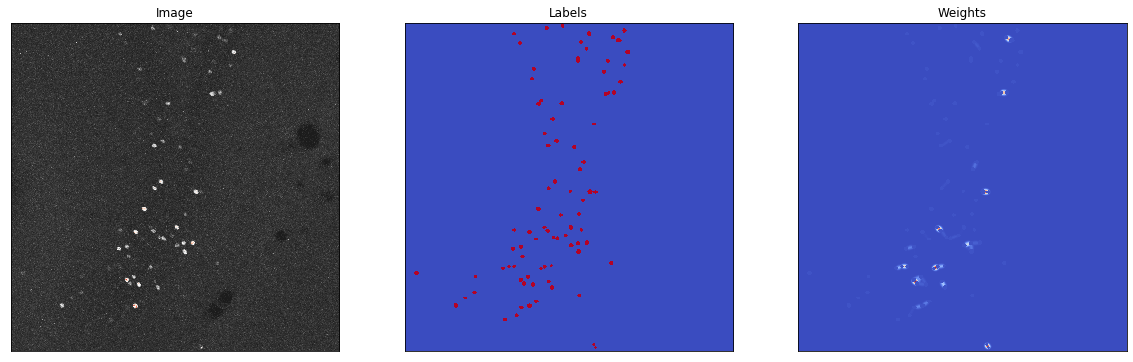

In [0]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=2)

# Data Preparation

**Data Augmentation** <br>SETTINGS<br>Change augmentation values here or modifiy get_custom_transforms()

In [0]:
DEFORMATION = True    #elastic deformation with magnitude SIGMA and number ob gridpoints GRID_DIVS
SIGMA = 6
GRID_DIVS = 8

RAND_CROP = True    #random crop of image?

ROTATION_MAX_ANGLE = 10     #max rotation in degrees

LIGHT_CONTRAST_CHANGE = 0.01    #max increase of brightness/contrast

TRANSFORM_VALID = True    #also transform validation dataset

xtra_tfms = None  #add extra transforms as list here, e.g. xtra_tfms = [jitter()]

Calculate the range of center coordinates for random crop

In [0]:
# gets original size of raw images
original_size = utility.get_image_size(f'{IMG_PATH}/{img_ids[0]}{imgExt}')

# min distance from any border of the image in percent (tuple for x and y):
row_col_per = np.divide(np.add(np.multiply(0.5,TILE_SHAPE),1),original_size)

# ranges for row_pct and col_pct for initial_crop_pad(**rand_pos):
rand_pos = {'row_pct':(row_col_per[0],1-row_col_per[0]), 'col_pct':(row_col_per[1],1-row_col_per[1])}

Visualization of deformation grid

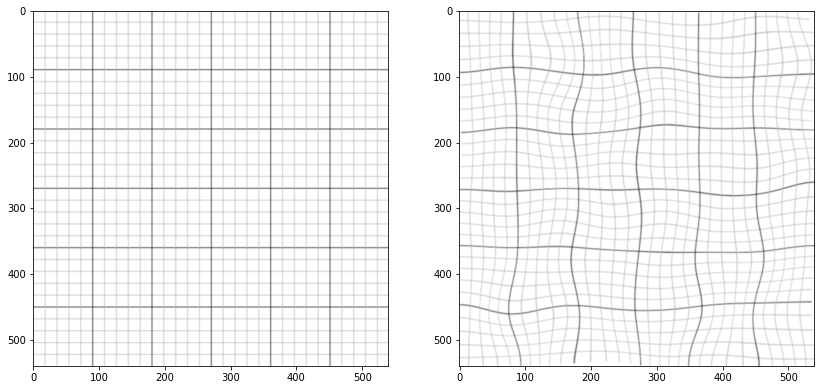

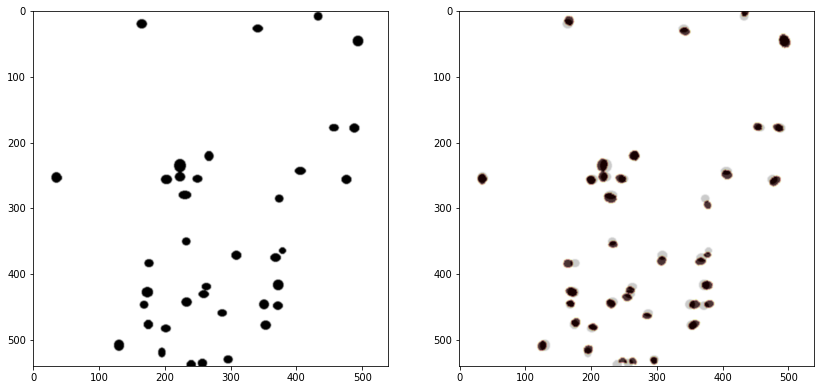

In [0]:
example_img = io.imread(get_labels(img_ids[2]))

utility.test_deformation(shape=TILE_SHAPE,sigma=SIGMA,points=GRID_DIVS)
utility.test_deformation(shape=TILE_SHAPE,example_img=example_img, sigma=SIGMA,points=GRID_DIVS)

**Custom 'get_transforms()' function for selected augmentations**

Transforms are generally applied on train set only, but this can be changed with 'transform_valid_ds = True'. Standard transforms on train set include: 

*   randomly mirror image on x- and y-axis
*   light brightness and contrast shift
*   random rotation
*   elastic deformation





In [0]:
tfms = get_custom_transforms(elastic_deformation= DEFORMATION,
                             random_crop= TILE_SHAPE if RAND_CROP else None,
                             elastic_deform_args= {'sigma':SIGMA, 'points':GRID_DIVS},
                             rand_pos= rand_pos, 
                             max_lighting= LIGHT_CONTRAST_CHANGE,
                             max_rotate= ROTATION_MAX_ANGLE,
                             transform_valid_ds= TRANSFORM_VALID,
                             xtra_tfms = xtra_tfms
                             )

**Create databunch object**

In [0]:
data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      # import from df in greyscale ('L')
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True)
      # apply data augmentation
      .databunch(bs=BATCH_SIZE)
      # set batchsize
)

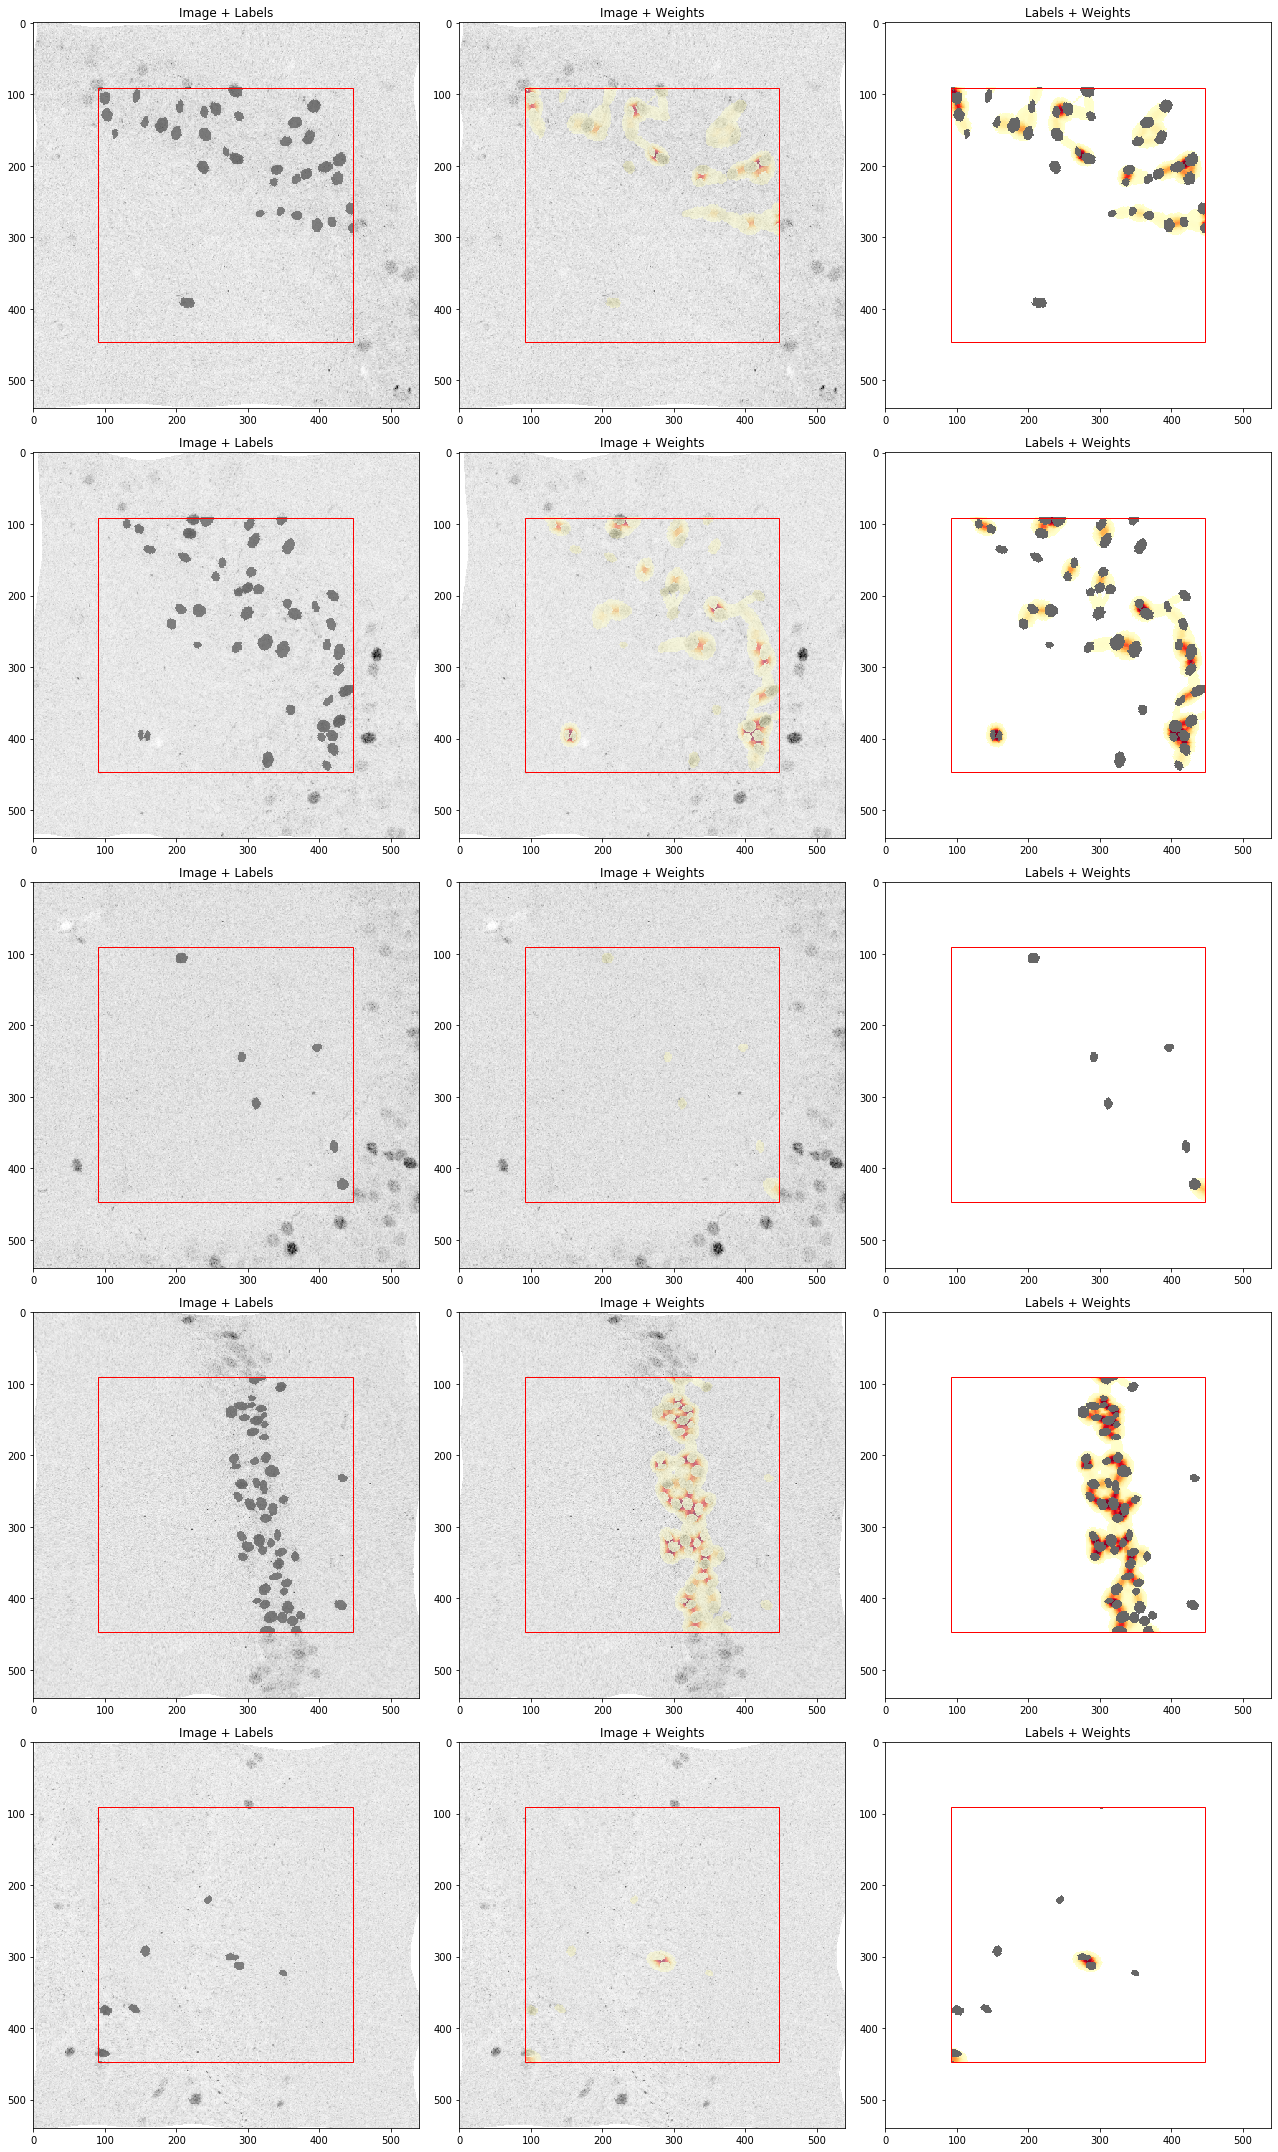

In [0]:
data.show_batch()

## Learner object and Training

Metrics

In [0]:
# metrics_wrapper let's you use any metric for this weighted-labels architecture 
# (get's rid of the weights and passes only labels to metric)
# if 'swap_preds = True' prediction and groundtruth are swapped (useful for sklearn.metrics)
# if 'softmax = True' all predictions will be normalized using nn.Softmax2d

IoU = metrics_wrapper(metric=dice, iou=True)
f1 = metrics_wrapper(metric=fbeta, beta=1) ##Ignore class 0, argmax result of softmax or round

Learner

In [0]:
# initiate kfold
kfold = KFold(N_SPLITS, True, SEED)

todays_folder = datetime.today().strftime('%y%d%m')

def initiate_learner():
  learn = Learner(data, 
                  net,
                  model_dir = f'{DIR}/model/{todays_folder}',
                  opt_func = torch.optim.Adam,
                  metrics = [IoU,f1],
                  loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='mean'),
                  callback_fns = ShowGraph,
                  wd = WEIGHT_DECAY)
  return learn

learn = initiate_learner()

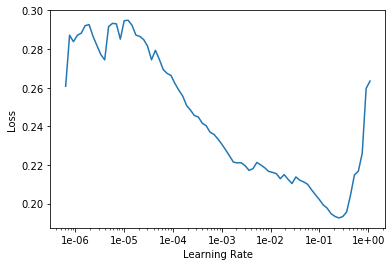

In [0]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

epoch,train_loss,valid_loss,dice,fbeta,time


KeyboardInterrupt: ignored

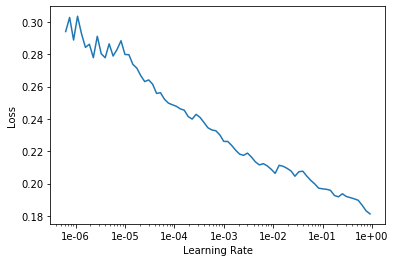

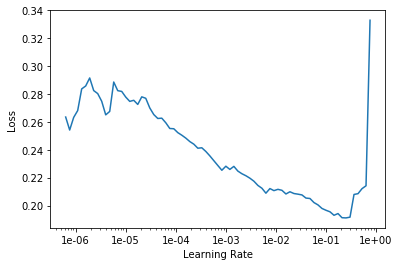

In [0]:
# actual datetime in yyddmm--hhmm
save_datetime = datetime.today().strftime('%y%d%m-%H%M')

# if kfold for first run
if INITIAL_KFOLD:
  
  #save initiation weights
  learn.save(f'initiation-stage-{save_datetime}')

  count = 0
  for train, test in kfold.split(img_df):
    
    #load initiation weights
    utility.blockPrint()
    learn = initiate_learner()
    learn.load(f'initiation-stage-{save_datetime}')

    #load data for this fold
    data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
        .split_by_idxs(train_idx=train, valid_idx=test)
        .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
        .transform(tfms=tfms, tfm_y=True)
        .databunch(bs=BATCH_SIZE)
    )
    utility.enablePrint()

    #change train-valid data
    learn.data = data

    #LR Finder
    learn.lr_find(end_lr=10)
    learn.recorder.plot()

    learn.save(f'initiatial-stage-{save_datetime}-{count}')
    learn.destroy().purge()

    count += 1

else:
  learn.lr_find(end_lr=10)
  learn.recorder.plot()

  stage_name = f'initiatial-stage-{save_datetime}-no-kfold'
  learn.save(stage_name)



epoch,train_loss,valid_loss,dice,fbeta,time
0,0.111865,0.143832,0.028477,0.044954,00:19
1,0.111242,0.120481,0.019687,0.031916,00:17
2,0.110123,0.115669,0.031739,0.042507,00:16
3,0.111207,0.183620,0.031365,0.038884,00:17
4,0.113883,0.076529,0.154329,0.027837,00:19
5,0.114432,0.213036,0.052764,0.045508,00:17
6,0.114933,0.093793,0.176415,0.042780,00:16
7,0.115063,0.146018,0.029539,0.053483,00:15
8,0.114481,0.124933,0.031393,0.039242,00:16
9,0.112664,0.083790,0.108382,0.035353,00:16


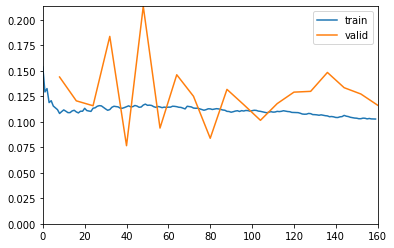

In [0]:
learn.fit_one_cycle(20,max_lr=2e-4)

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [0]:
# get filename
file_name = f'initial-stage-{save_datetime}'
print(f'This save: {file_name}')

# save to drive
learn.save(file_name)

This save: initial-stage-201103-1538
this object has been destroyed


In [0]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [0]:
count = 0

# enumerate splits
for train, test in kfold.split(img_df):
  
  # load initial-stage (file_name)
  utility.blockPrint()
  learn = initiate_learner()
  learn.load(file_name)

  # set name of fold
  fold_name = f'kfold-stage1-{save_datetime}-{count}'

  #print(f'{fold_name}:')

  #load data for this fold
  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_idxs(train_idx=train, valid_idx=test)
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True)
      # apply data augmentation, 'nearest' to avoid interpolation of the masks
      .databunch(bs=BATCH_SIZE)
      # set batchsize
  )
  utility.enablePrint()

  # swap data of Leaner
  learn.data = data

  # train
  learn.fit(20,wd=WEIGHT_DECAY, lr=slice(None,4e-4,None))

  # save and destroy learner
  learn.save(fold_name)
  learn.destroy().purge()

  count += 1
  sys.stderr.write(str(count))
  

In [0]:
kfold

#Testing